# Implementing quantum channels in a quantum computer using smaller registers

__Implementation of quantum channels using a smaller quantum register by factorizing the target quantum channel into Kraus deficient channels__

In this notebook I construct quantum circuits to simulate two singular quantum channels using a register with a size smaller than the one dictated by the [__Stinespring theorem__](https://www.quantiki.org/wiki/church-larger-hilbert-space). For qubit channels, the minimum environment dimension needed is

$$\mathcal{E}[\rho]=\sum_{i=1}^{4}{K_i \rho K_i^\dagger{}}$$

<!--<img src="images/circuit.jpeg" width="400" class="center">
-->

## Functions and libraries needed

In [3]:
# Importing libraries for the construction of the quantum circuit
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister, execute
# Importing also numpy, will be needed later
import numpy as np
from qiskit.providers.ibmq import least_busy

In [4]:
#Loading account
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [5]:
# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
from qiskit.tools.monitor import job_monitor

/tmp/ipykernel_1888305/3764712384.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In order to compute how close is the implemented to the theoretical one, we compute the fidelity among them.

In [6]:
#Linear Algebra functions
from numpy import dot, trace
from numpy.linalg import matrix_power, multi_dot
from scipy.linalg import sqrtm

In [7]:
#Plotting functions
import matplotlib.pyplot as plt

## Constructing circuits for the implementation of total depolarizing channel

The following unitaries simulate the total depolarizing channel according to the aforementioned decomposition.

In [18]:
#Define the same uniteries as in the last section just to ilustrate. 
U=[[0,0,0,1],
   [0,1,0,0],
   [0,0,1,0],
   [1,0,0,0]
  ]
U2=[[1,0,0,0],
   [0,2**-0.5,2**-0.5,0],
   [0,2**-0.5,-2**-0.5,0],
    [0,0,0,1]
   ]
U3=[[0,0,1,0],
   [2**-0.5,0,0,2**-0.5],
   [-2**-0.5,0,0,2**-0.5],
    [0,1,0,0]
   ]

In [19]:
#Creation of quantum and classical registers and putting them together
q = QuantumRegister(2)
c = ClassicalRegister(1)
qc=QuantumCircuit(q,c)

I define below the unitaries that are going to implement each part of our channel

In [20]:
qc.unitary(U,[0,1],'$U_{boundary}$')
qc.measure(1,0)
qc.x([1]).c_if(c, 0)
qc.unitary(U2,[0,1],'$U_{e^{\mathcal{L}}}$')

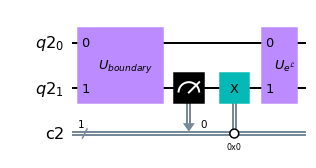

In [21]:
qc.draw('mpl')

_Transpiling_ the circuit so that it can be implemented in the quantum computer. This process is made by IBM anyway.

In [22]:
trans_qc=transpile(qc,basis_gates=['cx','u3','u','cz'],optimization_level=3)

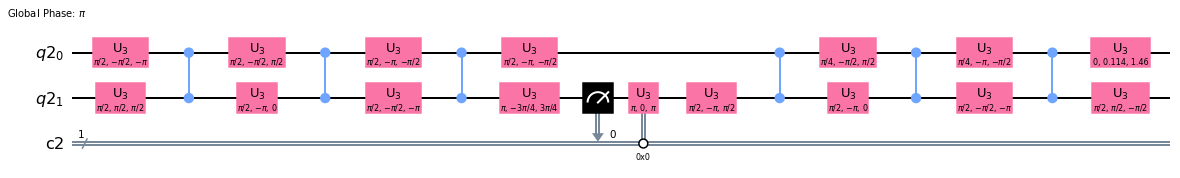

In [23]:
trans_qc.draw('mpl')

### Quantum process tomography

First we start session in IBM Quantum

Quantum process tomography is the procedure to 

In [24]:
backend='ibmq_lima'
quamtum_computer= provider.get_backend(backend)

In [25]:
qpt_circs = process_tomography_circuits(trans_qc,q[1],prepared_qubits=q[1])

In [26]:
job = execute(qpt_circs,backend=quamtum_computer, shots=10000)

job_monitor(job)

Job Status: job incurred error     


In [2]:
# qpt_tomo_comp = ProcessTomographyFitter(job.result(), qpt_circs)

Unfortunately the used IBM 5-qubit computers don not support unitary gates controlled by bits. To overcome this and still prove the concept, we use the principle of [deferred measurement](https://en.wikipedia.org/wiki/Deferred_Measurement_Principle). This is, basically we will use a quantum bit as a classical bit, but to avoid unnecessary operations (for instance a SWAP to always use the same qubit as classical qubit), we simply use the first environmental qubit as a quantum control for the second stage.

# Implementing a singular channel using only the decomposition with 3 qubits

In the following I construct a circuit that implements the following singular channel in the qubit $0$: 
$$\left(
\begin{array}{cccc}
 1 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 \\
 0 & 0 & 0  & 0 \\
 0 & 0 & 0 & \lambda  \\
\end{array}
\right)$$
The channel is written in the Pauli basis $1/\sqrt{2}\{\mathbb{1},\sigma_x,\sigma_y,\sigma_z \}$.

In this example we made use only of the __Lindblad-Boundary__ decomposition, and not of the advantage of the ancilla size reduction, as we need anyway three qubits to initialize properly the second ancilla.

In [19]:
U=[[0,0,1,0],
   [0,1,0,0],
   [1,0,0,0],
   [0,0,0,1]
  ]
l=0.75
gm=(1-l)**0.5/(2**0.5)
gp=(1+l)**0.5/(2**0.5)
U2=[[0,gm,0,-gp],
   [gm,0,-gp,0],
   [gp,0,gm,0],
    [0,gp,0,gm]]
U3=[[0,-gp,0,gm],
   [-gp,0,gm,0],
   [gm,0,gp,0],
     [0,gm,0,gp]]

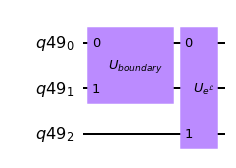

In [20]:
q = QuantumRegister(3)
qc=QuantumCircuit(q)
qc.unitary(U,[0,1],'$U_{boundary}$')
#qc.cnot([1],[2])
qc.unitary(U2,[0,2],label='$U_{e^{\mathcal{L}}}$')
#cU1=qc1.to_gate(label='$U_{e^{\mathcal{L}}}$').control(1,ctrl_state=0)
qc.draw('mpl')

### Quantum process tomography

In [9]:
backend='ibmq_quito'
quamtum_computer= provider.get_backend(backend)

In [10]:
qpt_circs = process_tomography_circuits(qc,q[0],prepared_qubits=q[0])

In [17]:
#joblist2dec=[]
for i in range(2):
    job = execute(qpt_circs,backend=quamtum_computer, shots=20000)
    print(i)
    job_monitor(job)
    joblist2dec.append(job)

0
Job Status: job has successfully run
1
Job Status: job has successfully run


In [22]:
chois2dec=list(map(lambda r: ProcessTomographyFitter(r.result(), qpt_circs).fit(),joblist2dec))
chois2dec=list(map(np.array,chois2dec))

In [23]:
len(chois2dec)

10

In [24]:
theoreticalchoi2=np.diag(0.5*np.array([1+l,1-l,1-l,1+l]))

In [56]:
fidelities2dec

[(0.9954003619482998-4.641032297039247e-17j),
 (0.9954523398087629+1.0583556077116377e-16j),
 (0.9954946833967737+8.670254628915249e-18j),
 (0.9945802870424951-2.591866064307436e-18j),
 (0.995786608881142-4.3296638177119495e-18j),
 (0.9957938191980285-5.89964658838384e-17j),
 (0.9951553629686074-1.3882969924388075e-17j),
 (0.9958287428952262+1.735170158520008e-17j),
 (0.9957487234906935-1.3122264250580849e-17j),
 (0.9956884195241263-5.205371523413456e-18j)]

In [25]:
fidelities2dec=[]
for k in chois2dec:
    fidelities2dec.append(trace(sqrtm(multi_dot([sqrtm(theoreticalchoi2),k,sqrtm(theoreticalchoi2)])))/2)

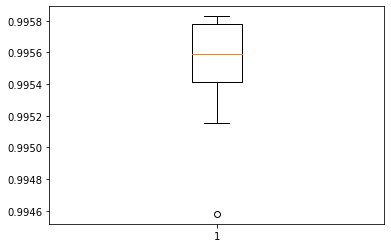

In [26]:
plt.boxplot(np.real(fidelities2dec))
plt.show()

In [30]:
#import csv
#b = open('chois2dec.csv', 'w')
#a = csv.writer(b)
#a.writerows(chois2dec)
#b.close()

# Using deferred measurement and effectively only 2 qubits (unnecessarily complicated circuit controlling two unitaries, just to see how it works)

In the following I construct a circuit that implements the following singular channel in the qubit $0$: 
$$\left(
\begin{array}{cccc}
 1 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 \\
 0 & 0 & 0  & 0 \\
 0 & 0 & 0 & \lambda  \\
\end{array}
\right)$$
The channel is written in the Pauli basis $1/\sqrt{2}\{\mathbb{1},\sigma_x,\sigma_y,\sigma_z \}$.

In this case we do not only make use of the __Lindblad-Boundary__ decomposition, but also of the register size reduction. We use the __deferred measurement__ and __implicit measurement__ principles.

In [6]:
U=[[0,0,1,0],
   [0,1,0,0],
   [1,0,0,0],
   [0,0,0,1]
  ]
l=0.75
gm=(1-l)**0.5/(2**0.5)
gp=(1+l)**0.5/(2**0.5)
U2=[[0,gm,0,-gp],
   [gm,0,-gp,0],
   [gp,0,gm,0],
    [0,gp,0,gm]]
U3=[[0,-gp,0,gm],
   [-gp,0,gm,0],
   [gm,0,gp,0],
     [0,gm,0,gp]]

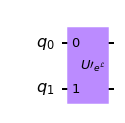

In [7]:
qc1=QuantumCircuit(2)
qc1.unitary(U2,[0,1],'$U_{e^{\mathcal{L}}}$')
qc2=QuantumCircuit(2)
qc2.unitary(U3,[0,1],'$U{\prime}_{e^{\mathcal{L}}}$')
qc2.draw('mpl')

In the following, the third qubit is used as a classical qubit due to the fact that the quantum computer used does not support classically controlled unitary gates.

Therefore, we use a CNOT gate to change the state of the third qubit according to the final environmental state

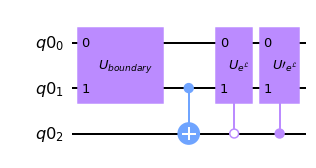

In [8]:
q = QuantumRegister(3)
qc=QuantumCircuit(q)
qc.unitary(U,[0,1],'$U_{boundary}$')
qc.cnot([1],[2])
cU1=qc1.to_gate(label='$U_{e^{\mathcal{L}}}$').control(1,ctrl_state=0)
qc.append(cU1,[2,0,1])
cU2=qc2.to_gate(label='$U{\prime}_{e^{\mathcal{L}}}$').control(1,ctrl_state=1)
qc.append(cU2,[2,0,1])
qc.draw('mpl')
#cU1=qc1.to_gate(label='$U_{e^{\mathcal{L}}}$').control(1,ctrl_state=0)

In [17]:
qctrans=transpile(qc,optimization_level=3)

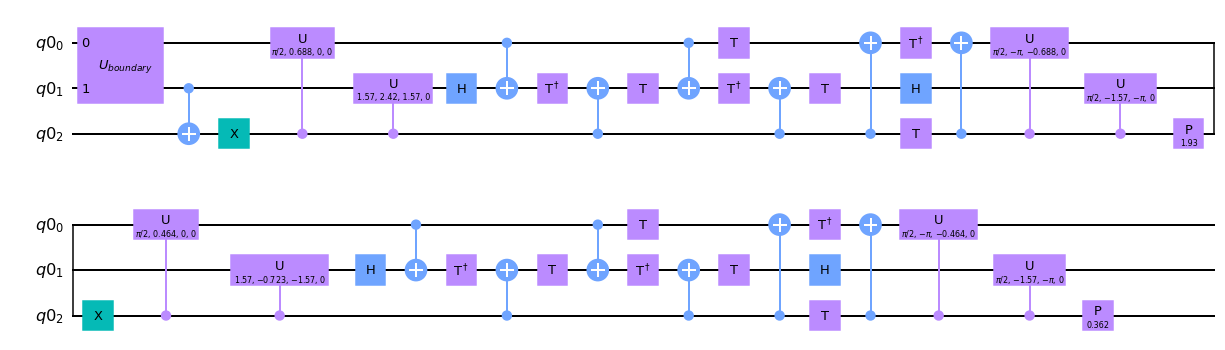

In [18]:
qctrans.draw('mpl')

### Quantum process tomography

In [10]:
backend='ibmq_lima'
quamtum_computer= provider.get_backend(backend)

In [11]:
qpt_circs = process_tomography_circuits(qc,q[0],prepared_qubits=q[0])

In [ ]:
joblist2=[]
for i in range(10):
    job = execute(qpt_circs,backend=quamtum_computer, shots=20000)
    print(i)
    job_monitor(job)
    joblist2.append(job)

In [51]:
theoreticalchoi2=np.diag(0.5*np.array([1+l,1-l,1-l,1+l]))

In [47]:
chois2=list(map(lambda r: ProcessTomographyFitter(r.result(), qpt_circs).fit(),joblist2))
chois2=list(map(np.array,chois2))
len(chois2)

4

In [49]:
np.round(chois2[3],1)

array([[ 0.7+0.j ,  0.1-0.1j, -0. -0.j , -0. +0.j ],
       [ 0.1+0.1j,  0.3+0.j ,  0.2+0.j ,  0. +0.j ],
       [-0. +0.j ,  0.2-0.j ,  0.4+0.j , -0.1-0.j ],
       [-0. -0.j ,  0. -0.j , -0.1+0.j ,  0.6+0.j ]])

In [58]:
fidelities2=[]
for k in chois2:
    fidelities2.append(trace(sqrtm(multi_dot([sqrtm(theoreticalchoi2),k,sqrtm(theoreticalchoi2)])))/2)

First bunch of fidelities

In [57]:
fidelities2

[(0.96988773459573+2.4363251288173247e-17j),
 (0.9673439505668706+1.0383621470586337e-17j),
 (0.9706917461535958-1.2119049077468252e-17j),
 (0.9731782805614134-2.783637732144719e-17j),
 (0.9793223008532475+1.0427513507551162e-16j),
 (0.9746951654415983-3.7495441301597173e-17j),
 (0.9620702614671094+5.192001045082164e-18j),
 (0.9728893029934645-2.2608107114385593e-17j),
 (0.96580200683517-3.3476691079544817e-17j),
 (0.960841071237759-1.6434684432783862e-17j),
 (0.9612494302754113-2.5850421102322812e-17j)]

Second bunch of fidelities

In [59]:
fidelities2

[(0.9649689559610533+1.7115800995250324e-17j),
 (0.9731194781888718-4.52873917725153e-17j),
 (0.9540497186084765+4.139635320924562e-18j),
 (0.9430663799823709+6.950716091685994e-17j)]

Third bunch of fidelities

In [ ]:
fidelities2

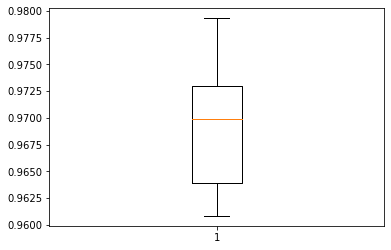

In [83]:
plt.boxplot(np.real(fidelities2))
plt.show()

# Using deferred measurement and effectively only 2 qubits (simpler circuit)

In the following I construct a circuit that implements the following singular channel in the qubit $0$: 
$$\left(
\begin{array}{cccc}
 1 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 \\
 0 & 0 & 0  & 0 \\
 0 & 0 & 0 & \lambda  \\
\end{array}
\right)$$
The channel is written in the Pauli basis $1/\sqrt{2}\{\mathbb{1},\sigma_x,\sigma_y,\sigma_z \}$.

In this case we do not only make use of the __Lindblad-Boundary__ decomposition, but also of the register size reduction. We use the __deferred measurement__ and __implicit measurement__ principles.

In [6]:
U=[[0,0,1,0],
   [0,1,0,0],
   [1,0,0,0],
   [0,0,0,1]
  ]
l=0.75
gm=(1-l)**0.5/(2**0.5)
gp=(1+l)**0.5/(2**0.5)
U2=[[0,gm,0,-gp],
   [gm,0,-gp,0],
   [gp,0,gm,0],
    [0,gp,0,gm]]
U3=[[0,-gp,0,gm],
   [-gp,0,gm,0],
   [gm,0,gp,0],
     [0,gm,0,gp]]

In the following, the third qubit is used as a classical qubit due to the fact that the quantum computer used does not support classically controlled unitary gates.

Therefore, we use a CNOT gate to change the state of the third qubit according to the final environmental state

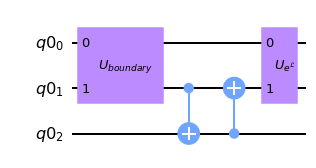

In [7]:
q = QuantumRegister(3)
qc=QuantumCircuit(q)
qc.unitary(U,[0,1],'$U_{boundary}$')
qc.cnot([1],[2])
qc.cnot([2],[1])
qc.unitary(U2,[0,1],'$U_{e^{\mathcal{L}}}$')
qc.draw('mpl')
#cU1=qc1.to_gate(label='$U_{e^{\mathcal{L}}}$').control(1,ctrl_state=0)

### Quantum process tomography

In [56]:
backend='ibmq_lima'
quamtum_computer= provider.get_backend(backend)

In [57]:
qpt_circs = process_tomography_circuits(qc,q[0],prepared_qubits=q[0])

In [ ]:
#joblist2=[]
for i in range(10):
    job = execute(qpt_circs,backend=quamtum_computer, shots=20000)
    print(i)
    job_monitor(job)
    joblist2.append(job)

0
Job Status: job is queued (20)    

In [48]:
theoreticalchoi2=np.diag(0.5*np.array([1+l,1-l,1-l,1+l]))

In [49]:
chois2=list(map(lambda r: ProcessTomographyFitter(r.result(), qpt_circs).fit(),joblist2))
chois2=list(map(np.array,chois2))
len(chois2)

10

In [49]:
np.round(chois2[3],1)

array([[ 0.7+0.j ,  0.1-0.1j, -0. -0.j , -0. +0.j ],
       [ 0.1+0.1j,  0.3+0.j ,  0.2+0.j ,  0. +0.j ],
       [-0. +0.j ,  0.2-0.j ,  0.4+0.j , -0.1-0.j ],
       [-0. -0.j ,  0. -0.j , -0.1+0.j ,  0.6+0.j ]])

In [50]:
fidelities2=[]
for k in chois2:
    fidelities2.append(trace(sqrtm(multi_dot([sqrtm(theoreticalchoi2),k,sqrtm(theoreticalchoi2)])))/2)

In [52]:
chois2[1]

array([[ 0.87815 +0.j      ,  0.0104  -0.03035j ,  0.001725-0.040975j,
         0.0119  -0.011j   ],
       [ 0.0104  +0.03035j ,  0.12185 +0.j      , -0.0066  -0.0091j  ,
        -0.001725+0.040975j],
       [ 0.001725+0.040975j, -0.0066  +0.0091j  ,  0.1649  +0.j      ,
         0.0046  +0.00495j ],
       [ 0.0119  +0.011j   , -0.001725-0.040975j,  0.0046  -0.00495j ,
         0.8351  +0.j      ]])

First bunch of fidelities

In [51]:
fidelities2

[(0.9977811302434743+6.245846924318826e-17j),
 (0.9979512319727428+6.245373310050654e-17j),
 (0.9981040089169582-7.98293433432561e-17j),
 (0.9974170359037349-1.2149154054422256e-16j),
 (0.9971635306336362+3.4724722221161965e-17j),
 (0.9975915892041071+6.423604834872988e-17j),
 (0.997674513635429-5.3782264596977516e-17j),
 (0.9973184022920231-3.7740811015075004e-17j),
 (0.9973848897718072-7.982758482976066e-17j),
 (0.9981296207795207+7.46043197285274e-17j)]

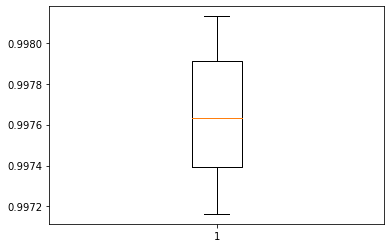

In [60]:
plt.boxplot(np.real(fidelities2))
plt.show()